In [179]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from flaml import AutoML
# from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
# from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

from variance_reduction.diff_in_means import DifferenceInMeans
from variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect, diff_in_means
from variance_reduction.mlrate import MLRATE, AltMLRATE
from variance_reduction.cupac import CUPAC
from variance_reduction.doubly_robust import DoublyRobustEstimator
from variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll, VREvaluationGrid
from variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple synthetic data

In [3]:
def generate_synthetic_data(n):

    # pre experiment metric
    group_0 = np.random.exponential(10, n//2)
    group_1 = np.random.exponential(10, n//2)

    pre_metric = np.concatenate([group_0, group_1])

    # experiment metric
    ctrl_group_0 = group_0 + np.random.normal(0,1, n//2)
    treatment_group_1 = group_1 + np.random.normal(5,1, n//2) + np.random.normal(0,1, n//2)

    exp_metric = np.concatenate([ctrl_group_0, treatment_group_1])

    # treatment
    treatment = np.concatenate([np.zeros(n//2), np.ones(n//2)])

    # assemble dataframe
    df = pd.DataFrame({
        'Y': exp_metric,
        'T': treatment,
        'X': pre_metric
    })

    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [4]:
simple_synthetic_df = generate_synthetic_data(10000)

# More complicated synthetic data


In [5]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [6]:

nonlinear_synthetic_df = dgp(n=10000, p=20, linear=False, constant=True)
linear_synthetic_df = dgp(n=10000, p=20, linear=True, constant=True)

# Big evaluation of nonlinear synthetic data

In [326]:
base_params_map= {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'X1'
    },

    'MultivariateCUPED': {
        'covariate_columns': None
    },

    'MultivariateRegression': {
        'covariate_columns': None
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': None
    },


    # 'CUPAC': {
    #     'pre_experiment_data': 'ml_synthetic_df',
    #     'covariate_columns': list(ml_synthetic_df.columns[2:10]),
    #     'model': HistGradientBoostingRegressor,
    #     'model_init_config': {},
    #     'model_fit_config': {}
    # },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': None,
        'model': None,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': None,
        'model_regression': None,
        'model_propensity': 'auto',
        'mc_iters':5
    }

}

In [327]:
parameter_grid = VREvaluationGrid.generate_parameters_grid(base_methods_params_map=base_params_map,
                         covariate_columns_list = [nonlinear_synthetic_df.columns.to_list()[0:4*i] for i in range(1,6)],
                         models = [ElasticNet, LGBMRegressor],
                         model_init_configs = [{}, {}],
                         model_fit_configs = [{}, {}])

In [328]:
evaluation_grid = VREvaluationGrid([DifferenceInMeans, CUPED, MultivariateRegression, MultivariateRegressionAdjusted, MultivariateCUPED, MLRATE])
evaluation_grid = evaluation_grid.run(data=nonlinear_synthetic_df, 
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_grid=parameter_grid)

----- Running evaluation for parameter grid index (0, 0)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 105.30it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 46.94it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:01<00:00, 50.10it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:02<00:00, 34.96it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 46.15it/s]


Running MLRATE...


100%|██████████| 100/100 [00:04<00:00, 24.23it/s]


Done!
----- Running evaluation for parameter grid index (0, 1)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 133.67it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 44.86it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:04<00:00, 22.38it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 43.73it/s]


Running MLRATE...


100%|██████████| 100/100 [00:04<00:00, 22.94it/s]


Done!
----- Running evaluation for parameter grid index (0, 2)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 104.99it/s]


Running CUPED...


100%|██████████| 100/100 [00:01<00:00, 50.74it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:03<00:00, 33.01it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 40.41it/s]


Running MLRATE...


100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


Done!
----- Running evaluation for parameter grid index (0, 3)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:01<00:00, 97.41it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 40.12it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:03<00:00, 26.50it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 37.05it/s]


Running MLRATE...


100%|██████████| 100/100 [00:05<00:00, 19.90it/s]


Done!
----- Running evaluation for parameter grid index (0, 4)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:01<00:00, 96.45it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 43.06it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Running MLRATE...


100%|██████████| 100/100 [00:04<00:00, 21.07it/s]


Done!
----- Running evaluation for parameter grid index (1, 0)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 120.38it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:02<00:00, 47.64it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:03<00:00, 26.25it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 43.28it/s]


Running MLRATE...


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Done!
----- Running evaluation for parameter grid index (1, 1)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:01<00:00, 92.19it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 41.52it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:03<00:00, 33.18it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:04<00:00, 20.61it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 37.51it/s]


Running MLRATE...


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Done!
----- Running evaluation for parameter grid index (1, 2)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 108.78it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 42.16it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:03<00:00, 25.85it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 33.98it/s]


Running MLRATE...


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Done!
----- Running evaluation for parameter grid index (1, 3)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:03<00:00, 25.64it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 44.44it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 36.08it/s]


Running MLRATE...


100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


Done!
----- Running evaluation for parameter grid index (1, 4)... -----
Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 106.63it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 34.65it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:04<00:00, 23.24it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 37.34it/s]


Running MLRATE...


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]

Done!


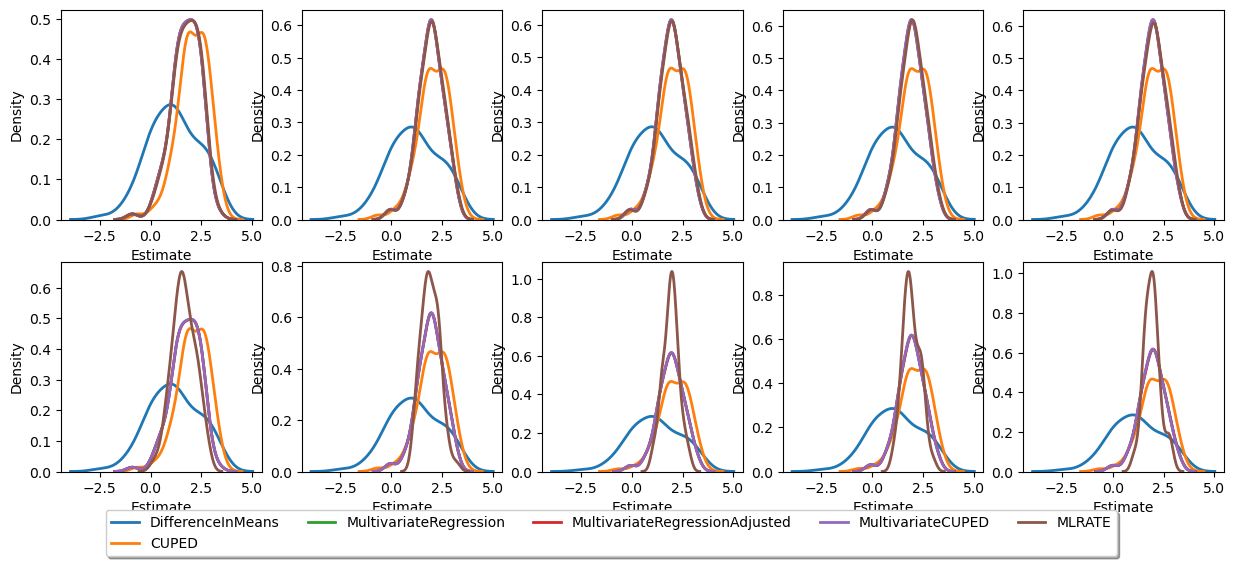

In [329]:
evaluation_grid.plot_grid()